## CNN classifier for multi label tagging of Myntra fashion products

In [2]:
# Execute only in colab
!pip uninstall tensorflow
!pip install tensorflow==1.15.0

Uninstalling tensorflow-2.2.0rc2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc2
     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 512kB 41.7MB/s 
     |████████████████████████████████| 3.8MB 41.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=0e1f52a4070bee2ed13c4db4993b3236d38f81216d7acc20e01dd198efc8ba4b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstal

In [3]:
import numpy as np
import pandas as pd
import os
import PIL
import sys
import time
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD

from keras.preprocessing.image import load_img, img_to_array

from google.colab import files
print('tensorflow version: ', tf.__version__)

tensorflow version:  1.15.0


Using TensorFlow backend.


##### If you are working on your local computer. Download and extract the dataset from https://www.kaggle.com/paramaggarwal/fashion-product-images-small
##### As the productDisplayName column in styles.csv needed modification. Extract only the images folder into your CNN_model_fashion_products_multi_label_tagging/images/ directory. Make use of styles.csv from this repository.

In [0]:
folder_path = os.getcwd()
# folder_path = os.path.join(folder_path, 'CNN_model_fashion_products_multi_label_tagging')

### Run below cell only in google colab
##### Upload your kaggle.json file into colab before you run below cell.
##### Download the kaggle.json file from your kaggle Profile/Account/API by clicking "Create New API Token".

In [11]:
!git clone https://github.com/sharathrjtr/CNN_model_fashion_products_multi_label_tagging.git
folder_path = os.path.join(folder_path, 'CNN_model_fashion_products_multi_label_tagging')

# Download the Kaggle Myntra fashion products small dataset
# For details: https://github.com/Kaggle/kaggle-api

# Two methods to authenticate your kaggle account. 

# Method 1: Fill in the details of username and key below from the kaggle.json.
# os.environ['KAGGLE_USERNAME'] = "username"
# os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxx"

# Method 2: If kaggle.json is already uploaded in colab directory /content/
os.environ['KAGGLE_CONFIG_DIR']='/content/'

!kaggle datasets download -d paramaggarwal/fashion-product-images-small

# Unzip the download dataset into the CNN model directory excluding the styles.csv and directory myntradataset/
!unzip fashion-product-images-small.zip -x styles.csv myntradataset/* -d CNN_model_fashion_products_multi_label_tagging/myntradataset/

Streaming output truncated to the last 5000 lines.
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58129.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/5813.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58131.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58132.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58133.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58135.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58136.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58137.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58138.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58139.jpg  
  inflating: CNN_mod

In [0]:
def cleanup_csv_mapping(mapping_csv):
    # articleType can be used to find subCategory and masterCategory. 
    # Year specifies particular year the product is made, productDisplayName is something unique to the product and not a generalization.
    # Hence, we are dropping masterCategory, subCartegory, year and productDisplayName columns from the data frame.
    mapping_csv.drop(['masterCategory', 'subCategory', 'year', 'productDisplayName'], axis=1, inplace=True)

    # Drop the samples which don't have any value in any of the columns.
    mapping_csv.dropna(inplace=True)
    mapping_csv.head()
    
    return mapping_csv

In [0]:
# create a list of tags available among gender, articleType, baseColour, season and usage
# generate a mapping from tags to integers and integers to tags
def extract_tags_mapping(mapping_csv):
    labels = set()
    labels_gender = set()
    labels_article_type = set()
    labels_base_colour = set()
    labels_season = set()
    labels_usage = set()
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        labels.update([gender, article_type, base_colour, season, usage])
        labels_gender.update([gender])
        labels_article_type.update([article_type])
        labels_base_colour.update([base_colour])
        labels_season.update([season])
        labels_usage.update([usage])
    print('Total labels:', len(labels))

    # convert the labels to a list and sort them alphabetically
    labels = list(labels)
    # order set alphabetically
    labels.sort()

    labels_gender = list(labels_gender)
    labels_gender.sort()
    labels_article_type = list(labels_article_type)
    labels_article_type.sort()
    labels_base_colour = list(labels_base_colour)
    labels_base_colour.sort()
    labels_season = list(labels_season)
    labels_season.sort()
    labels_usage = list(labels_usage)
    labels_usage.sort()
    
    # create dictionary that maps labels to integers so that we can encode the training dataset for modeling.
    # create a dictionary with reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.
    labels_map = {labels[i]: i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}

    gender_map = {labels_gender[i]: i for i in range(len(labels_gender))}
    inv_gender_map = {i:labels_gender[i] for i in range(len(labels_gender))}
    articletype_map = {labels_article_type[i]: i for i in range(len(labels_article_type))}
    inv_articletype_map = {i:labels_article_type[i] for i in range(len(labels_article_type))}
    color_map = {labels_base_colour[i]: i for i in range(len(labels_base_colour))}
    inv_color_map = {i:labels_base_colour[i] for i in range(len(labels_base_colour))}
    season_map = {labels_season[i]: i for i in range(len(labels_season))}
    inv_season_map = {i:labels_season[i] for i in range(len(labels_season))}
    usage_map = {labels_usage[i]: i for i in range(len(labels_usage))}
    inv_usage_map = {i:labels_usage[i] for i in range(len(labels_usage))}
    
    # return labels_map, inv_labels_map,
    return gender_map, inv_gender_map, articletype_map, inv_articletype_map, color_map, inv_color_map, season_map, inv_season_map, usage_map, inv_usage_map

In [0]:
# obtain distribution of samples over the all labels
def distribution_samples_labels(mapping_csv, labels_gender, labels_article_type, labels_base_colour, labels_season, labels_usage):
    num_samples_gender = [0]*len(labels_gender)
    num_samples_article_type = [0]*len(labels_article_type)
    num_samples_base_colour = [0]*len(labels_base_colour)
    num_samples_season = [0]*len(labels_season)
    num_samples_usage = [0]*len(labels_usage)

    for index, row in mapping_csv.iterrows():
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']

        num_samples_gender[labels_gender[gender]] += 1
        num_samples_article_type[labels_article_type[article_type]] += 1
        num_samples_base_colour[labels_base_colour[base_colour]] += 1
        num_samples_season[labels_season[season]] += 1
        num_samples_usage[labels_usage[usage]] += 1
    
    return num_samples_gender, num_samples_article_type, num_samples_base_colour, num_samples_season, num_samples_usage

In [0]:
# extract the training images filename and labels for all images.
def extract_img_ids_labels(mapping_csv):
    image_ids = []
    image_labels = dict()
    num_sample_per_label = np.zeros(len(image_labels), dtype='int16')
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        if os.path.exists(folder_path+'/myntradataset/images/'+str(fileid)+'.jpg'):
            image_ids.append(fileid)
            image_labels[fileid] = [gender, article_type, base_colour, season, usage]
    
    print('Number of train files: ', len(image_ids))
    
    return image_ids, image_labels

In [0]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [0]:
# load images and extract labels in one hot encode form
def load_dataset(image_ids, image_labels, tag_mapping):
    images, targets = list(), list()
    # enumerate file in the directory
    for filename in image_ids:
        # load image
        image = load_img(os.path.join(folder_path+'/myntradataset/images', str(filename)+'.jpg'), target_size=(60,80))
        # convert to numpy array
        image = img_to_array(image, dtype='uint8')
        # get tags
        tags = image_labels[filename]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store train image and tags
        images.append(image)
        targets.append(target)
    
    X = np.asarray(images, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

In [14]:
csv_filename = folder_path+'/myntradataset/styles.csv'
# Read the csv file and clean up the file to extract relevant data
# productDisplayName column consist of extra commas for few row. 
# These were manually removed as it can result in error during reading of the file
mapping_csv = pd.read_csv(csv_filename)
print('Dataset Mapping dataframe size before cleanup: ', mapping_csv.shape)

mapping_csv = cleanup_csv_mapping(mapping_csv)
print('Dataset Mapping dataframe size after cleanup: ', mapping_csv.shape)
mapping_csv.head()

Dataset Mapping dataframe size before cleanup:  (44446, 10)
Dataset Mapping dataframe size after cleanup:  (44101, 6)


,id,gender,articleType,baseColour,season,usage
0,15970,Men,Shirts,Navy Blue,Fall,Casual
1,39386,Men,Jeans,Blue,Summer,Casual
2,59263,Women,Watches,Silver,Winter,Casual
3,21379,Men,Track Pants,Black,Fall,Casual
4,53759,Men,Tshirts,Grey,Summer,Casual



sample dist for article type:  142
Accessory Gift Set :  111
Baby Dolls :  14
Backpacks :  724
Bangle :  85
Basketballs :  13
Bath Robe :  17
Beauty Accessory :  3
Belts :  813
Blazers :  8
Body Lotion :  3
Body Wash and Scrub :  1
Booties :  12
Boxers :  52
Bra :  477
Bracelet :  66
Briefs :  847
Camisoles :  39
Capris :  175
Caps :  283
Casual Shoes :  2846
Churidar :  30
Clothing Set :  8
Clutches :  290
Compact :  39
Concealer :  11
Cufflinks :  106
Cushion Covers :  1
Deodorant :  347
Dresses :  464
Duffel Bag :  88
Dupatta :  116
Earrings :  417
Eye Cream :  4
Eyeshadow :  32
Face Moisturisers :  47
Face Scrub and Exfoliator :  4
Face Serum and Gel :  2
Face Wash and Cleanser :  16
Flats :  500
Flip Flops :  916
Footballs :  8
Formal Shoes :  637
Foundation and Primer :  69
Fragrance Gift Set :  57
Free Gifts :  91
Gloves :  20
Hair Accessory :  1
Hair Colour :  19
Handbags :  1759
Hat :  3
Headband :  7
Heels :  1323
Highlighter and Blush :  38
Innerwear Vests :  242
Ipad :  1


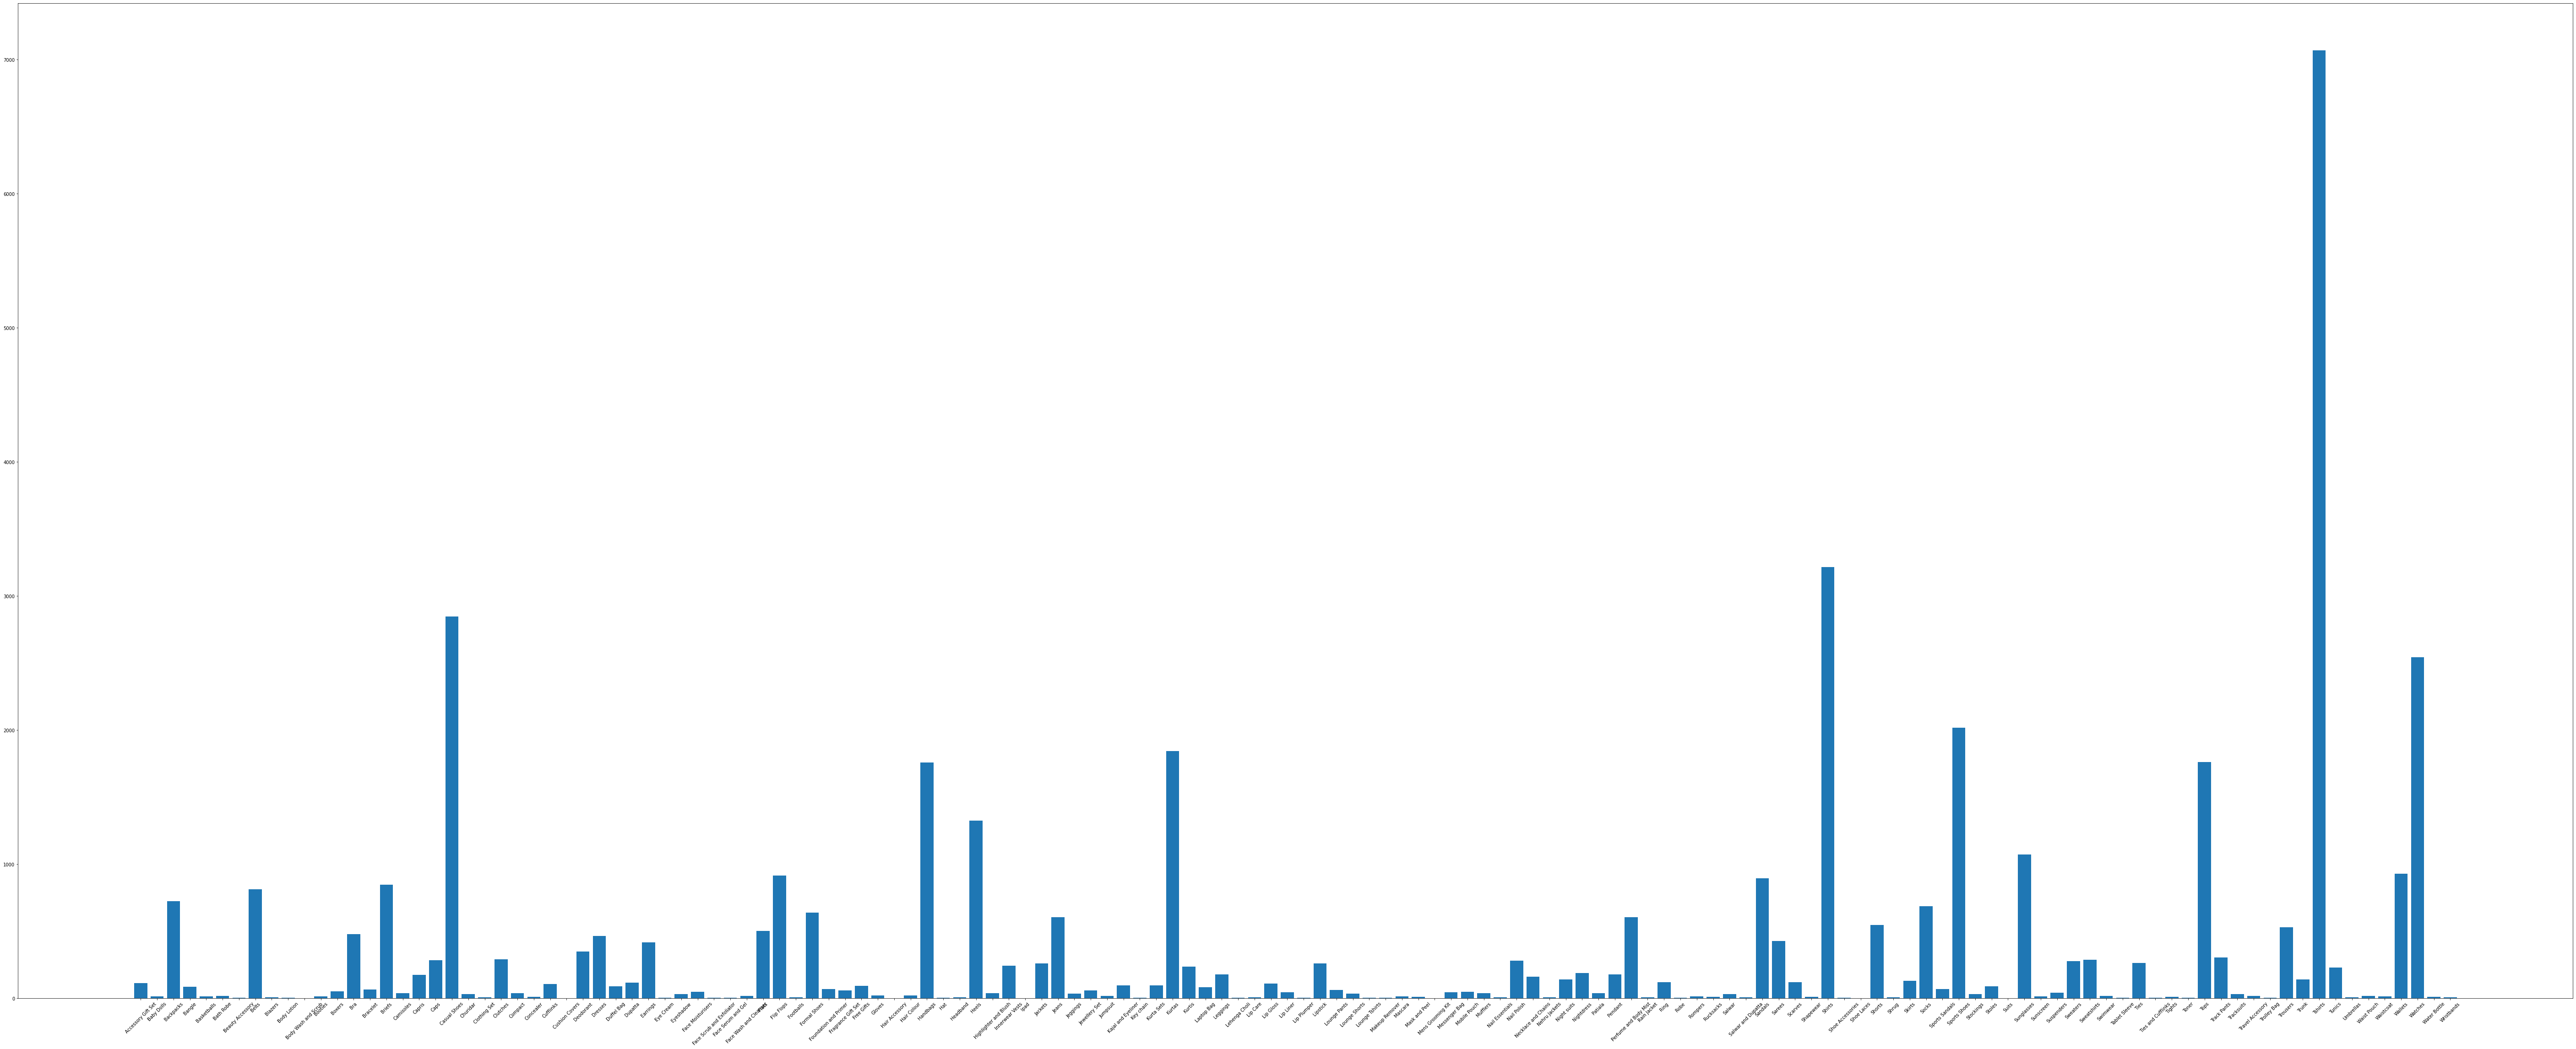

In [46]:
# extract mapping from labels to indices and indices to labels
# labels_to_idx, idx_to_labels, labels_gender, labers_article_type, labels_base_colour, labels_season, labels_usage = extract_tags_mapping(mapping_csv)
# gender_idx, idx_gender, article_idx, idx_article, color_idx, idx_color, season_idx, idx_season, usage_idx, idx_usage = extract_tags_mapping(mapping_csv)

# plot distribution of samples over dataset available
# num_samples_gender, num_samples_article_type, num_samples_base_colour, num_samples_season, num_samples_usage = distribution_samples_labels(mapping_csv, gender_idx, article_idx, color_idx, season_idx, usage_idx)
# print('\nsample dist for gender: ', len(num_samples_gender))
# for i in range(len(num_samples_gender)):
#     print(idx_gender[i], ': ', num_samples_gender[i])
# pyplot.figure(figsize=(10,10))
# pyplot.bar(gender_idx.keys(), num_samples_gender)
# pyplot.xticks(rotation=45)

print('\nsample dist for article type: ', len(num_samples_article_type))
for i in range(len(num_samples_article_type)):
    print(idx_article[i], ': ', num_samples_article_type[i])
pyplot.figure(figsize=(100,40))
pyplot.bar(article_idx.keys(), num_samples_article_type)
t = pyplot.xticks(rotation=45)

# print('\nsample dist for base color: ', len(num_samples_base_colour))
# for i in range(len(num_samples_base_colour)):
#     print(idx_color[i], ': ', num_samples_base_colour[i])

# print('\nsample dist for season: ', len(num_samples_season))
# for i in range(len(num_samples_season)):
#     print(idx_season[i], ': ', num_samples_season[i])

# print('\nsample dist for usage: ', len(num_samples_usage))
# for i in range(len(num_samples_usage)):
#     print(idx_usage[i], ': ', num_samples_usage[i])

# pyplot.figure(figsize=(10,10))
# pyplot.bar(gender_idx.keys(), num_samples_gender)
# pyplot.xticks(rotation=45)
# pyplot.savefig('distribution of samples.png')
# pyplot.close()

# extract the images filename and tags for training dataset
# train_ids, train_labels = extract_img_ids_labels(mapping_csv)

In [0]:
# load the dataset, the actual images and labels for each image with one-hot encoding
train_images, train_tags = load_dataset(train_ids, train_labels, labels_to_idx)
print('Total Images shape: ', train_images.shape, 'Total tags shape: ', train_tags.shape)

# Total size of image loaded will be about 60*80*3*44101*8 / (1000000000*8) = 0.635GB
# save both arrays to one file in compressed format
np.savez_compressed(folder_path+'/myntra_train_data.npz', train_images, train_tags)

#### From here on we work on the saved myntra_train_data.npz file

In [0]:
def load_saved_dataset():
    data = np.load(folder_path+'/myntra_train_data.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state = 1)
    print('Train images Shape: ', trainX.shape, 'Train labels shape:', trainY.shape)
    print('Test images shape: ', testX.shape, 'Test labels shape: ', testY.shape)
    
    return trainX, trainY, testX, testY

In [0]:
 # calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = keras.backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + keras.backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + keras.backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
    return fbeta_score

In [5]:
trainX, trainY, testX, testY = load_saved_dataset()

# make all one predictions
train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

# evaluate predictions with keras
train_score = fbeta(keras.backend.variable(trainY), keras.backend.variable(train_yhat))
test_score = fbeta(keras.backend.variable(testY), keras.backend.variable(test_yhat))

if tf.__version__ > "1.15.0":
  print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))
else:
  print('All Ones (keras): train=%.3f, test=%.3f' % (keras.backend.eval(train_score), keras.backend.eval(test_score)))


Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
All Ones: train=0.111, test=0.111






All Ones (keras): train=0.111, test=0.111


In [0]:
# define cnn model
def define_baseline_model(in_shape=(60,80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history, figname, epochs):
    fig = pyplot.figure(figsize=(15,5))
    fig.tight_layout()

    # plot loss
    pyplot.subplot(121)    
    pyplot.plot(range(1,epochs+1,1), history.history['loss'], color='blue', label='train_loss')
    pyplot.plot(range(1,epochs+1,1), history.history['val_loss'], color='orange', label='val_loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Cross Entropy Loss')
    pyplot.title(figname+': Cross Entropy Loss')
    pyplot.legend()

    # plot fbeta score
    pyplot.subplot(122)
    pyplot.plot(range(1,epochs+1,1), history.history['fbeta'], color='blue', label='train_fbeta_score')
    pyplot.plot(range(1,epochs+1,1), history.history['val_fbeta'], color='orange', label='val_fbeta_score')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Fbeta Score')
    pyplot.title(figname+': Fbeta Score')
    pyplot.legend()

    # save plot to file
    filename = folder_path + '/' + figname
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [0]:
# run the test harness for evaluating a model
def run_test_harness(model, figname, epochs, height_shift_range=0.0, width_shift_range=0.0, shear_range=0.0, hor_flip=False, vert_flip=False, rot_range=0, featurewise_center=False):
    # load dataset
    trainX, trainY, testX, testY = load_saved_dataset()
    # create data generator
    if featurewise_center:
        datagen = ImageDataGenerator(featurewise_center = True, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
        # specify imagenet mean values for centering
        datagen.mean = [123.68, 116.779, 103.939]
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history, figname, epochs)

In [0]:
# run the test harness for baseline model
model = define_baseline_model()
run_test_harness(model, 'Baseline', 50)

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/50
242/242 [==============================] - 20s 84ms/step - loss: 0.1201 - fbeta: 0.2801 - val_loss: 0.0654 - val_fbeta: 0.2700
Epoch 2/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0640 - fbeta: 0.3233 - val_loss: 0.0630 - val_fbeta: 0.3215
Epoch 3/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0611 - fbeta: 0.3589 - val_loss: 0.0601 - val_fbeta: 0.3815
Epoch 4/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0589 - fbeta: 0.3860 - val_loss: 0.0580 - val_fbeta: 0.4307
Epoch 5/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0567 - fbeta: 0.4084 - val_loss: 0.0559 - val_fbeta: 0.3898
Epoch 6/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0543 - fbeta: 0.4355 - val_loss: 0.0538 - val_fbeta: 0.4326
Epoch 7/50
242/242 [=======

In [0]:
# define cnn model with dropout
def define_bl_dropout_model(in_shape=(60, 80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [19]:
# entry point, run the test harness for dropout model without augmentation
model = define_bl_dropout_model()
run_test_harness(model, 'Bl_Dropout', 200)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)


Epoch 1/200
242/242 [==============================] - 28s 117ms/step - loss: 0.2131 - fbeta: 0.2617 - val_loss: 0.0913 - val_fbeta: 0.2148
Epoch 2/200
242/242 [==============================] - 21s 85ms/step - loss: 0.0910 - fbeta: 0.3021 - val_loss: 0.0845 - val_fbeta: 0.2052
Epoch 3/200
242/242 [==============================] - 20s 85ms/step - loss: 0.0826 - fbeta: 0.2986 - val_loss: 0.0778 - val_fbeta: 0.2473
Epoch 4/200
242/242 [==============================] - 21s 85ms/step - loss: 0.0786 - fbeta: 0.2936 - val_loss: 0.0773 - val_fbeta: 0.3086
Epoch 5/200
242/242 [==============================] - 21s 86ms/step - loss: 0.0

In [0]:
# entry point, run the test harness for baseline model with augmentation
model = define_baseline_model()
run_test_harness(model, 'Bl_Img_Aug', 200, 0.1, 0.1, 0.1, True, True, 90)

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/200
242/242 [==============================] - 62s 258ms/step - loss: 0.1154 - fbeta: 0.2682 - val_loss: 0.0660 - val_fbeta: 0.2288
Epoch 2/200
242/242 [==============================] - 60s 248ms/step - loss: 0.0651 - fbeta: 0.2841 - val_loss: 0.0648 - val_fbeta: 0.2685
Epoch 3/200
242/242 [==============================] - 62s 255ms/step - loss: 0.0643 - fbeta: 0.2939 - val_loss: 0.0644 - val_fbeta: 0.2859
Epoch 4/200
242/242 [==============================] - 60s 249ms/step - loss: 0.0636 - fbeta: 0.3117 - val_loss: 0.0635 - val_fbeta: 0.3452
Epoch 5/200
242/242 [==============================] - 60s 248ms/step - loss: 0.0629 - fbeta: 0.3242 - val_loss: 0.0629 - val_fbeta: 0.3424
Epoch 6/200
242/242 [==============================] - 60s 248ms/step - loss: 0.0622 - fbeta: 0.3340 - val_loss: 0.0622 - val_fbeta: 0.3641
Epoch 7/200
242

In [0]:

# files.download(folder_path+'/Baseline_plot.png')
# files.download(folder_path+'/Bl_Dropout_plot.png')
# files.download(folder_path+'/Bl_Img_Aug_plot.png')
while not os.path.exists(folder_path + '/VGG_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_plot.png')

In [0]:
# define cnn model
def define_vgg_model(in_shape=(60, 80, 3), out_shape=205, model_trainable=False, dropout=False, lr=0.01):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    if model_trainable:
        # allow last vgg block to be trainable
        model.get_layer('block5_conv1').trainable = True
        model.get_layer('block5_conv2').trainable = True
        model.get_layer('block5_conv3').trainable = True
        model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
    if dropout:
        class2 = Dropout(0.5)(class1)
        output = Dense(out_shape, activation='sigmoid')(class2)
    else:
        output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/50
242/242 [==============================] - 29s 121ms/step - loss: 0.2445 - fbeta: 0.4182 - val_loss: 0.1487 - val_fbeta: 0.4870
Epoch 2/50
242/242 [==============================] - 28s 116ms/step - loss: 0.1365 - fbeta: 0.5034 - val_loss: 0.1336 - val_fbeta: 0.5133
Epoch 3/50
242/242 [==============================] - 28s 117ms/step - loss: 0.1211 - fbeta: 0.5289 - val_loss: 0.1172 - val_fbeta: 0.5219
Epoch 4/50
242/242 [==============================] - 28s 117ms/step - loss: 0.1064 - fbeta: 0.5484 - val_loss: 0.1043 - val_fbeta: 0.5447
Epoch 5/50
242/242 [==============================] - 28s 117ms/step - loss: 0.0982 - fbeta: 0.5646 - val_loss: 0.0995 - val_fbeta: 0.5643
Epoch 6/50
242/242 [==============================] - 29s 119ms/step - loss: 0.0936 - fbeta: 0.5745 - val_loss: 0.0959 - val_fbeta: 0.5567
Epoch 7/50
242/242 [=

MessageError: ignored

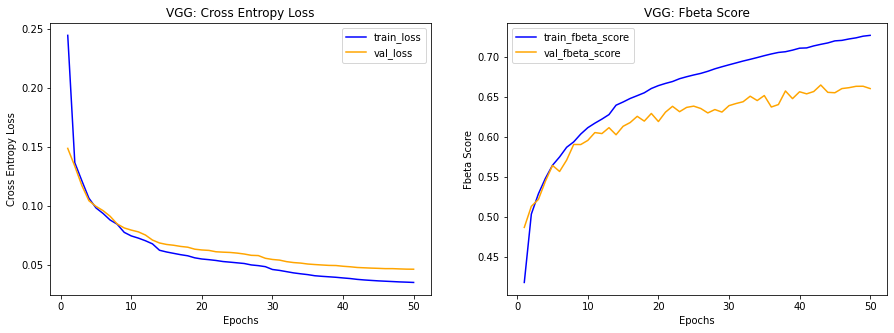

In [26]:
# entry point, run the test harness for vgg model without augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG', epochs=50, featurewise_center = True)

In [12]:
# run the test harness for VGG model with dropout at last layer
model = define_vgg_model(dropout=True)
run_test_harness(model, 'VGG_dropout', 50, featurewise_center = True)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)


Epoch 1/50
242/242 [==============================] - 36s 147ms/step - loss: 0.3604 - fbeta: 0.3673 - val_loss: 0.1889 - val_fbeta: 0.4490
Epoch 2/50
242/242 [==============================] - 28s 115ms/step - loss: 0.1901 - fbeta: 0.4420 - val_loss: 0.1474 - val_fbeta: 0.4799
Epoch 3/50
242/242 [==============================] - 28s 115ms/step - loss: 0.1391 - fbeta: 0.4760 - val_loss: 0.0919 - val_fbeta: 0.4999
Epoch 4/50
242/242 [==============================] - 28s 116ms/step - loss: 0.1000 - fbeta: 0.5002 - val_loss: 0.0728 - val_fbeta: 0.5309
Epoch 5/50
242/242 [==============================] - 28s 117ms/step - loss: 0.08

In [0]:
while not os.path.exists(folder_path + '/VGG_dropout_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_dropout_plot.png')

In [13]:
#run the test harness for VGG model with finetuning
model = define_vgg_model(model_trainable=True, lr=0.001)
run_test_harness(model, 'VGG_fine_tune', 50, featurewise_center = True)

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/50
242/242 [==============================] - 34s 139ms/step - loss: 0.7317 - fbeta: 0.2871 - val_loss: 0.6880 - val_fbeta: 0.2897
Epoch 2/50
242/242 [==============================] - 33s 137ms/step - loss: 0.2426 - fbeta: 0.2669 - val_loss: 0.0677 - val_fbeta: 0.2901
Epoch 3/50
242/242 [==============================] - 33s 136ms/step - loss: 0.0666 - fbeta: 0.2984 - val_loss: 0.0663 - val_fbeta: 0.2902
Epoch 4/50
242/242 [==============================] - 33s 136ms/step - loss: 0.0658 - fbeta: 0.2918 - val_loss: 0.0659 - val_fbeta: 0.2902
Epoch 5/50
242/242 [==============================] - 33s 137ms/step - loss: 0.0655 - fbeta: 0.3021 - val_loss: 0.0657 - val_fbeta: 0.2902
Epoch 6/50
242/242 [==============================] - 33s 136ms/step - loss: 0.0654 - fbeta: 0.2937 - val_loss: 0.0656 - val_fbeta: 0.3842
Epoch 7/50
242/242 [=

In [0]:
while not os.path.exists(folder_path + '/VGG_fine_tune_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_fine_tune_plot.png')

In [0]:
#run the test harness for VGG model and dropout with finetuning
model = define_vgg_model(model_trainable=True, dropout=True)
run_test_harness(model, 'VGG_dropout_fine_tune', 50, featurewise_center = True)

In [0]:
while not os.path.exists(folder_path + '/VGG_dropout_fine_tune_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_dropout_fine_tune_plot.png')

In [0]:
# entry point, run the test harness for VGG model with augmentation and finetuning
model = define_vgg_model()
run_test_harness(model, 'VGG_Img_Aug_fine_tune', 50, 0.1, 0.1, 0.1, True, True, 90, featurewise_center = True)

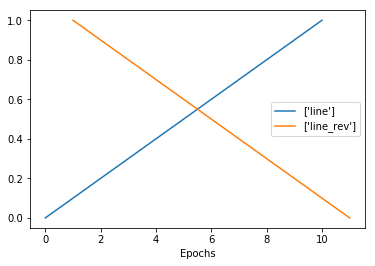

In [0]:
l=np.linspace(0,1,11)
# fig,ax=pyplot.figure(figsize=(6,4))
pyplot.figure()
pyplot.plot(range(11), l, label=['line'])
pyplot.plot(range(11,0,-1), l, label=['line_rev'])
pyplot.xlabel('Epochs')
pyplot.legend()
# pyplot.close()